In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import re
from itertools import product

In [ ]:
train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')
shops = pd.read_csv('shops.csv')
cats = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')

# Data Cleaning

1. Remove Outliers

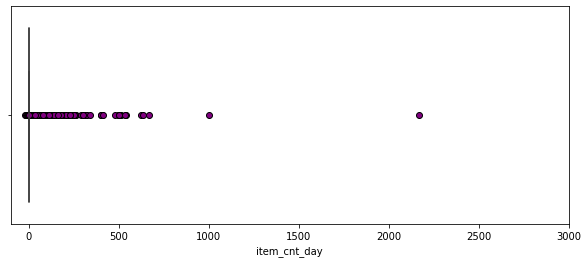

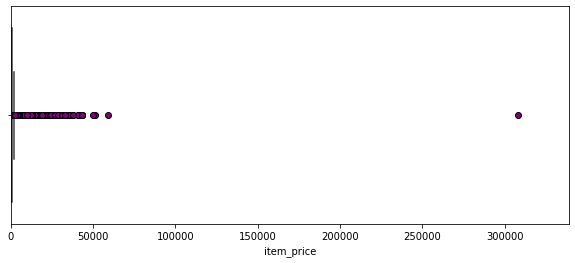

In [ ]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=train.item_cnt_day, flierprops=flierprops)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price, flierprops=flierprops)

In [ ]:
train = train[(train.item_price < 300000 ) & (train.item_cnt_day < 1000)]

In [ ]:
# remove negative price and sales count
train = train[train.item_price > 0].reset_index(drop = True)
train.loc[train.item_cnt_day < 1, "item_cnt_day"] = 0

2. Cleaning Shop Data

Several of the shops look like duplicates of each other. This could be down to shops re-opening or possibly moving store location on the same street or shopping centre.

In [ ]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [ ]:
# Clean up some shop names and add 'city' and 'category' to shops df.

shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops["category"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"
shops.head()

,shop_name,shop_id,city,category
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,"Орджоникидзе,"
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,ТЦ
2,"Адыгея ТЦ ""Мега""",2,Адыгея,ТЦ
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,ТРК
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,ТЦ


In [ ]:
# Only keep shop category if there are 5 or more shops of that category, the rest are grouped as "other".
category = []
for cat in shops.category.unique():
    if len(shops[shops.category == cat]) >= 5:
        category.append(cat)
shops.category = shops.category.apply( lambda x: x if (x in category) else "other" )
shops.head()

,shop_name,shop_id,city,category
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,other
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,ТЦ
2,"Адыгея ТЦ ""Мега""",2,Адыгея,ТЦ
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,ТРК
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,ТЦ


In [ ]:
# encode shop category and city using labelencoder
shops["shop_category"] = LabelEncoder().fit_transform( shops.category )
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )
shops = shops[["shop_id", "shop_category", "shop_city"]]
shops

,shop_id,shop_category,shop_city
0,0,0,29
1,1,4,29
2,2,4,0
3,3,2,1
4,4,4,2
5,5,3,3
6,6,0,4
7,7,3,4
8,8,3,4
9,9,0,5


3. Cleaning Item Category Data

In [ ]:
# split the category name and extract category type
cats["type_code"] = cats.item_category_name.apply( lambda x: x.split(" ")[0] ).astype(str)
cats.loc[ (cats.type_code == "Игровые")| (cats.type_code == "Аксессуары"), "category" ] = "Игры"
cats.head()

,item_category_name,item_category_id,type_code,category
0,PC - Гарнитуры/Наушники,0,PC,NaN
1,Аксессуары - PS2,1,Аксессуары,Игры
2,Аксессуары - PS3,2,Аксессуары,Игры
3,Аксессуары - PS4,3,Аксессуары,Игры
4,Аксессуары - PSP,4,Аксессуары,Игры


In [ ]:
# If a category type has >=5 categories, make it a type otherwise make it etc
category = []
for cat in cats.type_code.unique():
    if len(cats[cats.type_code == cat]) >= 5: 
        category.append( cat )
cats.type_code = cats.type_code.apply(lambda x: x if (x in category) else "etc")
cats

,item_category_name,item_category_id,type_code,category
0,PC - Гарнитуры/Наушники,0,etc,NaN
1,Аксессуары - PS2,1,Аксессуары,Игры
2,Аксессуары - PS3,2,Аксессуары,Игры
3,Аксессуары - PS4,3,Аксессуары,Игры
4,Аксессуары - PSP,4,Аксессуары,Игры
...,...,...,...,...
79,Служебные,79,etc,NaN
80,Служебные - Билеты,80,etc,NaN
81,Чистые носители (шпиль),81,etc,NaN
82,Чистые носители (штучные),82,etc,NaN


In [ ]:
# encode type_code using label encoder
cats.type_code = LabelEncoder().fit_transform(cats.type_code)

# extract subtype from category name and encode it
cats["split"] = cats.item_category_name.apply(lambda x: x.split("-"))
cats["subtype"] = cats.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats["subtype_code"] = LabelEncoder().fit_transform( cats["subtype"] )
cats = cats[["item_category_id", "subtype_code", "type_code"]]
cats

,item_category_id,subtype_code,type_code
0,0,29,0
1,1,9,1
2,2,10,1
3,3,11,1
4,4,13,1
...,...,...,...
79,79,54,0
80,80,25,0
81,81,62,0
82,82,63,0


4. Cleaning Item Data

In [ ]:
def name_correction(x):
    x = x.lower() # all letters lower case
    x = x.partition('[')[0] # partition by square brackets
    x = x.partition('(')[0] # partition by curly brackets
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters
    x = x.replace('  ', ' ') # replace double spaces with single spaces
    x = x.strip() # remove leading and trailing white space
    return x

In [ ]:
# Clean item names.

# split item names by first bracket
items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
items["name1"], items["name3"] = items.item_name.str.split("(", 1).str

# replace special characters and turn to lower case
items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()

# fill nulls with '0'
items = items.fillna('0')

items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))

# return all characters except the last if name 2 is not "0" - remove the closing bracket
items.name2 = items.name2.apply( lambda x: x[:-1] if x !="0" else "0")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """


In [ ]:
items.head(20)

,item_name,item_id,item_category_id,name1,name2,name3
0,во власти наваждения,0,40,! ВО ВЛАСТИ НАВАЖДЕНИЯ,0,пласт d
1,abbyy finereader 12 professional edition full,1,76,!ABBYY FineReader 12 Professional Edition Full...,pc цифровая версия,0
2,в лучах славы,2,40,***В ЛУЧАХ СЛАВЫ,0,unv d
3,голубая волна,3,40,***ГОЛУБАЯ ВОЛНА,0,univ d
4,коробка,4,40,***КОРОБКА,0,стекло d
5,новые американские граффити,5,40,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ,0,uni d
6,удар по воротам,6,40,***УДАР ПО ВОРОТАМ,0,uni d
7,удар по воротам 2,7,40,***УДАР ПО ВОРОТАМ-2,0,uni d
8,чай с муссолини d,8,40,***ЧАЙ С МУССОЛИНИ D,0,0
9,шугарлэндский экспресс,9,40,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС,0,uni d


In [ ]:
# Clean item type (type populated based on name2)

items["type"] = items.name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
items.loc[ items.type == "", "type"] = "mac"
items.type = items.type.apply( lambda x: x.replace(" ", "") )
items.loc[ (items.type == 'pc' )| (items.type == 'pс') | (items.type == "pc"), "type" ] = "pc"
items.loc[ items.type == 'рs3' , "type"] = "ps3"

items.head(20)

,item_name,item_id,item_category_id,name1,name2,name3,type
0,во власти наваждения,0,40,! ВО ВЛАСТИ НАВАЖДЕНИЯ,0,пласт d,0
1,abbyy finereader 12 professional edition full,1,76,!ABBYY FineReader 12 Professional Edition Full...,pc цифровая версия,0,pc
2,в лучах славы,2,40,***В ЛУЧАХ СЛАВЫ,0,unv d,0
3,голубая волна,3,40,***ГОЛУБАЯ ВОЛНА,0,univ d,0
4,коробка,4,40,***КОРОБКА,0,стекло d,0
5,новые американские граффити,5,40,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ,0,uni d,0
6,удар по воротам,6,40,***УДАР ПО ВОРОТАМ,0,uni d,0
7,удар по воротам 2,7,40,***УДАР ПО ВОРОТАМ-2,0,uni d,0
8,чай с муссолини d,8,40,***ЧАЙ С МУССОЛИНИ D,0,0,0
9,шугарлэндский экспресс,9,40,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС,0,uni d,0


In [ ]:
# how many items in each item type
group_sum = items.groupby(["type"]).agg({"item_id": "count"})
group_sum = group_sum.reset_index()
group_sum

,type,item_id
0,0,17661
1,5c5,1
2,5c7,2
3,5f4,1
4,6dv,1
5,6jv,1
6,6l6,1
7,android,3
8,hm3,1
9,j72,4


In [ ]:
# if a type has less than 40 items, make them into one single type called other
drop_cols = []
for cat in group_sum.type.unique():
    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <40:
        drop_cols.append(cat)

items.name2 = items.name2.apply( lambda x: "other" if (x in drop_cols) else x )
items = items.drop(["type"], axis = 1)

In [ ]:
# encode name2 and name3 
items.name2 = LabelEncoder().fit_transform(items.name2)
items.name3 = LabelEncoder().fit_transform(items.name3)

# name2 = string inside square brackets []
# name3 = string inside round brackets ()
# name1 = string on left of brackets
# item_name = string on left of brackets

# not sure why dropping these two columns
items.drop(["item_name", "name1"],axis = 1, inplace= True)
items.head()

,item_id,item_category_id,name2,name3
0,0,40,4,1331
1,1,76,64,42
2,2,40,4,1011
3,3,40,4,1010
4,4,40,4,1572


# Preprocessing

In [ ]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,0.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
# Create a matrix df with every combination of month, shop and item in order of increasing month. Item_cnt_day is summed into an item_cnt_month.

matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append( np.array(list( product( [i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype = np.int16) )

matrix = pd.DataFrame( np.vstack(matrix), columns = cols )
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )

In [ ]:
# add revenue to train df
train["revenue"] = train["item_cnt_day"] * train["item_price"]

In [ ]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,0.0,0.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00
...,...,...,...,...,...,...,...
2935840,10.10.2015,33,25,7409,299.00,1.0,299.00
2935841,09.10.2015,33,25,7460,299.00,1.0,299.00
2935842,14.10.2015,33,25,7459,349.00,1.0,349.00
2935843,22.10.2015,33,25,7440,299.00,1.0,299.00


In [ ]:
# get monthly item count
group = train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_day": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True)
group

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0
...,...,...,...,...
1609117,33,59,22087,6.0
1609118,33,59,22088,2.0
1609119,33,59,22091,1.0
1609120,33,59,22100,1.0


In [ ]:
# add monthly item count to matrix
matrix = pd.merge( matrix, group, on = cols, how = "left" )
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).astype(np.float16)
matrix

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0
...,...,...,...,...
10913799,33,59,22162,0.0
10913800,33,59,22163,0.0
10913801,33,59,22164,0.0
10913802,33,59,22166,0.0


In [ ]:
# Create a test set for month 34.
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [ ]:
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)

In [ ]:
# Concatenate train and test sets
matrix = pd.concat([matrix, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=cols)
matrix.fillna( 0, inplace = True )
matrix

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0
...,...,...,...,...
11127999,34,45,18454,0.0
11128000,34,45,16188,0.0
11128001,34,45,15757,0.0
11128002,34,45,19648,0.0


In [ ]:
# Add shop, items and categories data onto matrix df.
matrix = pd.merge( matrix, shops, on = ["shop_id"], how = "left" )
matrix = pd.merge(matrix, items, on = ["item_id"], how = "left")
matrix = pd.merge( matrix, cats, on = ["item_category_id"], how = "left" )
matrix["shop_city"] = matrix["shop_city"].astype(np.int8)
matrix["shop_category"] = matrix["shop_category"].astype(np.int8)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
matrix["subtype_code"] = matrix["subtype_code"].astype(np.int8)
matrix["name2"] = matrix["name2"].astype(np.int8)
matrix["name3"] = matrix["name3"].astype(np.int16)
matrix["type_code"] = matrix["type_code"].astype(np.int8)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,type_code
0,0,2,19,0.0,4,0,40,4,42,4,5
1,0,2,27,1.0,4,0,19,76,42,10,3
2,0,2,28,0.0,4,0,30,107,42,55,3
3,0,2,29,0.0,4,0,23,123,42,16,3
4,0,2,32,0.0,4,0,40,4,42,4,5
...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,4,20,55,4,42,2,7
11128000,34,45,16188,0.0,4,20,64,4,42,42,8
11128001,34,45,15757,0.0,4,20,55,4,42,2,7
11128002,34,45,19648,0.0,4,20,40,4,1367,4,5


# Feature Engineering

https://www.businessmanagementideas.com/sales/forecasting-sales/sales-forecasting-meaning-importance-and-methods/7122

Add additional features related to item count

In [ ]:
def add_feature(df, group_by, col, col_name):
  group = df.groupby( group_by ).agg({col : ["mean"]})
  group.columns = [col_name]
  group.reset_index(inplace = True)
  df = pd.merge(df, group, on = group_by, how = "left")
  df[col_name] = df[col_name].astype(np.float16)
  return df

In [ ]:
# average item count per month-shop-item_cat 
matrix = add_feature(matrix, ['date_block_num', 'shop_id', 'item_category_id'], "item_cnt_month", "month_shop_itemcat_avg_cnt")

In [ ]:
# average item count per month-shop-item_type
matrix = add_feature(matrix, ['date_block_num', 'shop_id', 'type_code'], "item_cnt_month", "month_shop_itemtype_avg_cnt")

In [ ]:
# average item count per month-shop_cat-item 
matrix = add_feature(matrix, ['date_block_num', 'shop_category', 'item_id'], "item_cnt_month", "month_shopcat_item_avg_cnt")

In [ ]:
# average item count per month-shop_cat-item_cat 
matrix = add_feature(matrix, ['date_block_num', 'shop_category', 'item_category_id'], "item_cnt_month", "month_shopcat_itemcat_avg_cnt")

In [ ]:
# average item count per month-city-item
matrix = add_feature(matrix, ['date_block_num', 'shop_city', 'item_id'], "item_cnt_month", "month_city_item_avg_cnt")

In [ ]:
# average item count per month-city-item_cat
matrix = add_feature(matrix, ['date_block_num', 'shop_city', 'item_category_id'], "item_cnt_month", "month_city_itemcat_avg_cnt")

In [ ]:
# average item count per month-shop
matrix = add_feature(matrix, ['date_block_num', 'shop_id'], "item_cnt_month", "month_shop_avg_cnt")

In [ ]:
# average item count per month-shop_cat
matrix = add_feature(matrix, ['date_block_num', 'shop_category'], "item_cnt_month", "month_shopcat_avg_cnt")

In [ ]:
# average item count per month-item
matrix = add_feature(matrix, ['date_block_num', 'item_id'], "item_cnt_month", "month_item_avg_cnt")

In [ ]:
# average item count per month-item_cat
matrix = add_feature(matrix, ['date_block_num', 'item_category_id'], "item_cnt_month", "month_itemcat_avg_cnt")

In [ ]:
# average item count per month-city
matrix = add_feature(matrix, ['date_block_num', 'shop_city'], "item_cnt_month", "month_city_avg_cnt")

In [ ]:
# average item count per month
matrix = add_feature(matrix, ['date_block_num'], "item_cnt_month", "month_avg_cnt")

In [ ]:
# average item count per item
matrix = add_feature(matrix, ['item_id'], "item_cnt_month", "item_avg_cnt")

In [ ]:
# average item count per shop
matrix = add_feature(matrix, ['shop_id'], "item_cnt_month", "shop_avg_cnt")

Add additional features related to date to capture cycle and seasonality


In [ ]:
# month
matrix['month'] = matrix['date_block_num']%12
matrix

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,type_code,month_shop_itemcat_avg_cnt,month_shop_itemtype_avg_cnt,month_shopcat_item_avg_cnt,month_shopcat_itemcat_avg_cnt,month_city_item_avg_cnt,month_city_itemcat_avg_cnt,month_shop_avg_cnt,month_shopcat_avg_cnt,month_item_avg_cnt,month_itemcat_avg_cnt,month_city_avg_cnt,month_avg_cnt,item_avg_cnt,shop_avg_cnt,month
0,0,2,19,0.0,4,0,40,4,42,4,5,0.073120,0.073853,0.000000,0.350586,0.0,0.073120,0.141846,0.392578,0.022217,0.311279,0.141846,0.361084,0.022217,0.128418,0
1,0,2,27,1.0,4,0,19,76,42,10,3,0.485107,0.467773,0.230713,0.944336,1.0,0.485107,0.141846,0.392578,0.155518,0.853516,0.141846,0.361084,0.056824,0.128418,0
2,0,2,28,0.0,4,0,30,107,42,55,3,0.539551,0.467773,0.153809,1.265625,0.0,0.539551,0.141846,0.392578,0.177734,1.192383,0.141846,0.361084,0.142822,0.128418,0
3,0,2,29,0.0,4,0,23,123,42,16,3,0.208374,0.467773,0.192261,0.578125,0.0,0.208374,0.141846,0.392578,0.111084,0.551758,0.141846,0.361084,0.040497,0.128418,0
4,0,2,32,0.0,4,0,40,4,42,4,5,0.073120,0.073853,7.460938,0.350586,0.0,0.073120,0.141846,0.392578,6.644531,0.311279,0.141846,0.361084,1.286133,0.128418,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,4,20,55,4,42,2,7,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.955566,0.175781,10
11128000,34,45,16188,0.0,4,20,64,4,42,42,8,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031006,0.175781,10
11128001,34,45,15757,0.0,4,20,55,4,42,2,7,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.227905,0.175781,10
11128002,34,45,19648,0.0,4,20,40,4,1367,4,5,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.103516,0.175781,10


In [ ]:
# year
import math
matrix['year'] = matrix['date_block_num']/12
matrix['year'] = matrix.year.apply(lambda x: math.floor(x))
matrix

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,type_code,month_shop_itemcat_avg_cnt,month_shop_itemtype_avg_cnt,month_shopcat_item_avg_cnt,month_shopcat_itemcat_avg_cnt,month_city_item_avg_cnt,month_city_itemcat_avg_cnt,month_shop_avg_cnt,month_shopcat_avg_cnt,month_item_avg_cnt,month_itemcat_avg_cnt,month_city_avg_cnt,month_avg_cnt,item_avg_cnt,shop_avg_cnt,month,year
0,0,2,19,0.0,4,0,40,4,42,4,5,0.073120,0.073853,0.000000,0.350586,0.0,0.073120,0.141846,0.392578,0.022217,0.311279,0.141846,0.361084,0.022217,0.128418,0,0
1,0,2,27,1.0,4,0,19,76,42,10,3,0.485107,0.467773,0.230713,0.944336,1.0,0.485107,0.141846,0.392578,0.155518,0.853516,0.141846,0.361084,0.056824,0.128418,0,0
2,0,2,28,0.0,4,0,30,107,42,55,3,0.539551,0.467773,0.153809,1.265625,0.0,0.539551,0.141846,0.392578,0.177734,1.192383,0.141846,0.361084,0.142822,0.128418,0,0
3,0,2,29,0.0,4,0,23,123,42,16,3,0.208374,0.467773,0.192261,0.578125,0.0,0.208374,0.141846,0.392578,0.111084,0.551758,0.141846,0.361084,0.040497,0.128418,0,0
4,0,2,32,0.0,4,0,40,4,42,4,5,0.073120,0.073853,7.460938,0.350586,0.0,0.073120,0.141846,0.392578,6.644531,0.311279,0.141846,0.361084,1.286133,0.128418,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,4,20,55,4,42,2,7,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.955566,0.175781,10,2
11128000,34,45,16188,0.0,4,20,64,4,42,42,8,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031006,0.175781,10,2
11128001,34,45,15757,0.0,4,20,55,4,42,2,7,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.227905,0.175781,10,2
11128002,34,45,19648,0.0,4,20,40,4,1367,4,5,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.103516,0.175781,10,2


In [ ]:
# season 
season = pd.Series([0,0,0,1,1,1,2,2,2,3,3,3])
matrix["season"] = matrix["month"].map(season).astype(np.int8)

In [ ]:
# number of days in the month
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int8)

Add additional features related to price

In [ ]:
# avg price per month-item
group = train.groupby( ['date_block_num', 'item_id'] ).agg({"item_price" : ["mean"]})
group.columns = ["month_avg_item_price"]
group.reset_index(inplace = True)
matrix = pd.merge(matrix, group, on = ['date_block_num', 'item_id'], how = "left")
matrix

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,type_code,month_shop_itemcat_avg_cnt,month_shop_itemtype_avg_cnt,month_shopcat_item_avg_cnt,month_shopcat_itemcat_avg_cnt,month_city_item_avg_cnt,month_city_itemcat_avg_cnt,month_shop_avg_cnt,month_shopcat_avg_cnt,month_item_avg_cnt,month_itemcat_avg_cnt,month_city_avg_cnt,month_avg_cnt,item_avg_cnt,shop_avg_cnt,month,year,season,days,month_avg_item_price
0,0,2,19,0.0,4,0,40,4,42,4,5,0.073120,0.073853,0.000000,0.350586,0.0,0.073120,0.141846,0.392578,0.022217,0.311279,0.141846,0.361084,0.022217,0.128418,0,0,0,31,28.000000
1,0,2,27,1.0,4,0,19,76,42,10,3,0.485107,0.467773,0.230713,0.944336,1.0,0.485107,0.141846,0.392578,0.155518,0.853516,0.141846,0.361084,0.056824,0.128418,0,0,0,31,2325.000000
2,0,2,28,0.0,4,0,30,107,42,55,3,0.539551,0.467773,0.153809,1.265625,0.0,0.539551,0.141846,0.392578,0.177734,1.192383,0.141846,0.361084,0.142822,0.128418,0,0,0,31,549.000000
3,0,2,29,0.0,4,0,23,123,42,16,3,0.208374,0.467773,0.192261,0.578125,0.0,0.208374,0.141846,0.392578,0.111084,0.551758,0.141846,0.361084,0.040497,0.128418,0,0,0,31,2397.500000
4,0,2,32,0.0,4,0,40,4,42,4,5,0.073120,0.073853,7.460938,0.350586,0.0,0.073120,0.141846,0.392578,6.644531,0.311279,0.141846,0.361084,1.286133,0.128418,0,0,0,31,338.110349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,4,20,55,4,42,2,7,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.955566,0.175781,10,2,3,30,NaN
11128000,34,45,16188,0.0,4,20,64,4,42,42,8,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031006,0.175781,10,2,3,30,NaN
11128001,34,45,15757,0.0,4,20,55,4,42,2,7,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.227905,0.175781,10,2,3,30,NaN
11128002,34,45,19648,0.0,4,20,40,4,1367,4,5,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.103516,0.175781,10,2,3,30,NaN


In [ ]:
# avg price per year-item
year_price = train[['date', 'item_id','item_price']]
year_price['year'] = year_price.apply(lambda row: int(row.date.split('.')[2])-2013, axis = 1)
year_price

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,date,item_id,item_price,year
0,02.01.2013,22154,999.00,0
1,03.01.2013,2552,899.00,0
2,05.01.2013,2552,899.00,0
3,06.01.2013,2554,1709.05,0
4,15.01.2013,2555,1099.00,0
...,...,...,...,...
2935840,10.10.2015,7409,299.00,2
2935841,09.10.2015,7460,299.00,2
2935842,14.10.2015,7459,349.00,2
2935843,22.10.2015,7440,299.00,2


In [ ]:
group = year_price.groupby( ['year', 'item_id'] ).agg({"item_price" : ["mean"]})
group.columns = ["year_avg_item_price"]
group.reset_index(inplace = True)
matrix = pd.merge(matrix, group, on = ['year', 'item_id'], how = "left")
matrix["year_avg_item_price"] = matrix['year_avg_item_price'].astype(np.float16)
matrix

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,type_code,month_shop_itemcat_avg_cnt,month_shop_itemtype_avg_cnt,month_shopcat_item_avg_cnt,month_shopcat_itemcat_avg_cnt,month_city_item_avg_cnt,month_city_itemcat_avg_cnt,month_shop_avg_cnt,month_shopcat_avg_cnt,month_item_avg_cnt,month_itemcat_avg_cnt,month_city_avg_cnt,month_avg_cnt,item_avg_cnt,shop_avg_cnt,month,year,season,days,month_avg_item_price,year_avg_item_price
0,0,2,19,0.0,4,0,40,4,42,4,5,0.073120,0.073853,0.000000,0.350586,0.0,0.073120,0.141846,0.392578,0.022217,0.311279,0.141846,0.361084,0.022217,0.128418,0,0,0,31,28.000000,28.0000
1,0,2,27,1.0,4,0,19,76,42,10,3,0.485107,0.467773,0.230713,0.944336,1.0,0.485107,0.141846,0.392578,0.155518,0.853516,0.141846,0.361084,0.056824,0.128418,0,0,0,31,2325.000000,1594.0000
2,0,2,28,0.0,4,0,30,107,42,55,3,0.539551,0.467773,0.153809,1.265625,0.0,0.539551,0.141846,0.392578,0.177734,1.192383,0.141846,0.361084,0.142822,0.128418,0,0,0,31,549.000000,311.2500
3,0,2,29,0.0,4,0,23,123,42,16,3,0.208374,0.467773,0.192261,0.578125,0.0,0.208374,0.141846,0.392578,0.111084,0.551758,0.141846,0.361084,0.040497,0.128418,0,0,0,31,2397.500000,1802.0000
4,0,2,32,0.0,4,0,40,4,42,4,5,0.073120,0.073853,7.460938,0.350586,0.0,0.073120,0.141846,0.392578,6.644531,0.311279,0.141846,0.361084,1.286133,0.128418,0,0,0,31,338.110349,308.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,4,20,55,4,42,2,7,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.955566,0.175781,10,2,3,30,NaN,186.5000
11128000,34,45,16188,0.0,4,20,64,4,42,42,8,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031006,0.175781,10,2,3,30,NaN,1257.0000
11128001,34,45,15757,0.0,4,20,55,4,42,2,7,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.227905,0.175781,10,2,3,30,NaN,206.8750
11128002,34,45,19648,0.0,4,20,40,4,1367,4,5,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.103516,0.175781,10,2,3,30,NaN,97.9375


In [ ]:
# avg price per year-item_cat
#year_avg_cat_price
year_cat_price = pd.merge(year_price,items[['item_id','item_category_id']], on = 'item_id', how = 'left')

In [ ]:
year_cat_price = year_cat_price[['item_price', 'year', 'item_category_id']].groupby( ['year', 'item_category_id'] ).agg({"item_price" : ["mean"]})
year_cat_price.columns = year_cat_price.columns.droplevel()
year_cat_price = year_cat_price.reset_index()
year_cat_price.columns = ['year', 'item_category_id', 'year_avg_cat_price']

In [ ]:
year_cat_price

,year,item_category_id,year_avg_cat_price
0,0,0,87.800000
1,0,1,215.500000
2,0,2,2149.426051
3,0,3,1258.355488
4,0,4,622.788241
...,...,...,...
211,2,79,1186.339569
212,2,80,1246.064128
213,2,81,350.000000
214,2,82,13.000000


In [ ]:
matrix = pd.merge(matrix, year_cat_price, on = ['year','item_category_id'], how = 'left')

In [ ]:
# avg item price
group = train.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)
matrix = pd.merge( matrix,group, on = ["item_id"], how = "left" )
matrix["item_avg_item_price"] = matrix['item_avg_item_price'].astype(np.float16)

Delta features

In [ ]:
#Lag features for change in price values
def lag_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [ ]:
lags = [1, 2, 3]
matrix = lag_feature( matrix, lags, ["month_avg_item_price"] )

month_avg_item_price


In [ ]:
for i in lags:
    matrix["delta_price_lag_" + str(i) ] = (matrix["month_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]

In [ ]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,type_code,month_shop_itemcat_avg_cnt,month_shop_itemtype_avg_cnt,month_shopcat_item_avg_cnt,month_shopcat_itemcat_avg_cnt,month_city_item_avg_cnt,month_city_itemcat_avg_cnt,month_shop_avg_cnt,month_shopcat_avg_cnt,month_item_avg_cnt,month_itemcat_avg_cnt,month_city_avg_cnt,month_avg_cnt,item_avg_cnt,shop_avg_cnt,month,year,season,days,month_avg_item_price,year_avg_item_price,year_avg_cat_price,item_avg_item_price,month_avg_item_price_lag_1,month_avg_item_price_lag_2,month_avg_item_price_lag_3,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3
0,0,2,19,0.0,4,0,40,4,42,4,5,0.073120,0.073853,0.000000,0.350586,0.0,0.073120,0.141846,0.392578,0.022217,0.311279,0.141846,0.361084,0.022217,0.128418,0,0,0,31,28.000000,28.0000,248.578945,28.000,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,4,0,19,76,42,10,3,0.485107,0.467773,0.230713,0.944336,1.0,0.485107,0.141846,0.392578,0.155518,0.853516,0.141846,0.361084,0.056824,0.128418,0,0,0,31,2325.000000,1594.0000,1514.601304,1461.000,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,4,0,30,107,42,55,3,0.539551,0.467773,0.153809,1.265625,0.0,0.539551,0.141846,0.392578,0.177734,1.192383,0.141846,0.361084,0.142822,0.128418,0,0,0,31,549.000000,311.2500,456.299900,310.000,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,4,0,23,123,42,16,3,0.208374,0.467773,0.192261,0.578125,0.0,0.208374,0.141846,0.392578,0.111084,0.551758,0.141846,0.361084,0.040497,0.128418,0,0,0,31,2397.500000,1802.0000,1543.248943,1759.000,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,4,0,40,4,42,4,5,0.073120,0.073853,7.460938,0.350586,0.0,0.073120,0.141846,0.392578,6.644531,0.311279,0.141846,0.361084,1.286133,0.128418,0,0,0,31,338.110349,308.0000,248.578945,249.625,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,4,20,55,4,42,2,7,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.955566,0.175781,10,2,3,30,NaN,186.5000,309.341769,188.625,99.0,99.000000,99.000000,-0.475149,-0.475149,-0.475149
11128000,34,45,16188,0.0,4,20,64,4,42,42,8,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031006,0.175781,10,2,3,30,NaN,1257.0000,1129.095644,1257.000,1359.0,1222.966667,NaN,0.081146,-0.027075,NaN
11128001,34,45,15757,0.0,4,20,55,4,42,2,7,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.227905,0.175781,10,2,3,30,NaN,206.8750,309.341769,198.125,229.0,229.000000,229.000000,0.155836,0.155836,0.155836
11128002,34,45,19648,0.0,4,20,40,4,1367,4,5,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.103516,0.175781,10,2,3,30,NaN,97.9375,271.537594,98.125,89.1,99.000000,94.857143,-0.091975,0.008917,-0.033303


In [ ]:
#Function to select just one change in price compared to the rest 3
def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

In [ ]:
matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_price_lag"] = matrix['delta_price_lag'].astype( np.float16 )
matrix["delta_price_lag"].fillna( 0 ,inplace = True)

In [ ]:
#Drop unwanted features 
features_to_drop = ["item_avg_item_price", "month_avg_item_price"]
for i in lags:
    features_to_drop.append("month_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)

In [ ]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,type_code,month_shop_itemcat_avg_cnt,month_shop_itemtype_avg_cnt,month_shopcat_item_avg_cnt,month_shopcat_itemcat_avg_cnt,month_city_item_avg_cnt,month_city_itemcat_avg_cnt,month_shop_avg_cnt,month_shopcat_avg_cnt,month_item_avg_cnt,month_itemcat_avg_cnt,month_city_avg_cnt,month_avg_cnt,item_avg_cnt,shop_avg_cnt,month,year,season,days,year_avg_item_price,year_avg_cat_price,delta_price_lag
0,0,2,19,0.0,4,0,40,4,42,4,5,0.073120,0.073853,0.000000,0.350586,0.0,0.073120,0.141846,0.392578,0.022217,0.311279,0.141846,0.361084,0.022217,0.128418,0,0,0,31,28.0000,248.578945,0.000000
1,0,2,27,1.0,4,0,19,76,42,10,3,0.485107,0.467773,0.230713,0.944336,1.0,0.485107,0.141846,0.392578,0.155518,0.853516,0.141846,0.361084,0.056824,0.128418,0,0,0,31,1594.0000,1514.601304,0.000000
2,0,2,28,0.0,4,0,30,107,42,55,3,0.539551,0.467773,0.153809,1.265625,0.0,0.539551,0.141846,0.392578,0.177734,1.192383,0.141846,0.361084,0.142822,0.128418,0,0,0,31,311.2500,456.299900,0.000000
3,0,2,29,0.0,4,0,23,123,42,16,3,0.208374,0.467773,0.192261,0.578125,0.0,0.208374,0.141846,0.392578,0.111084,0.551758,0.141846,0.361084,0.040497,0.128418,0,0,0,31,1802.0000,1543.248943,0.000000
4,0,2,32,0.0,4,0,40,4,42,4,5,0.073120,0.073853,7.460938,0.350586,0.0,0.073120,0.141846,0.392578,6.644531,0.311279,0.141846,0.361084,1.286133,0.128418,0,0,0,31,308.0000,248.578945,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,4,20,55,4,42,2,7,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.955566,0.175781,10,2,3,30,186.5000,309.341769,-0.475098
11128000,34,45,16188,0.0,4,20,64,4,42,42,8,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031006,0.175781,10,2,3,30,1257.0000,1129.095644,0.081116
11128001,34,45,15757,0.0,4,20,55,4,42,2,7,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.227905,0.175781,10,2,3,30,206.8750,309.341769,0.155884
11128002,34,45,19648,0.0,4,20,40,4,1367,4,5,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.103516,0.175781,10,2,3,30,97.9375,271.537594,-0.091980


Other features trend, first sales, last sell shops,…

In [ ]:
#Revenue for shops based on date
group = train.groupby( ["date_block_num","shop_id"] ).agg({"revenue": ["sum"] })
group.columns = ["date_shop_revenue"]
group.reset_index(inplace = True)
matrix = matrix.merge( group , on = ["date_block_num", "shop_id"], how = "left" )
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)


In [ ]:
# Shop avg revenue
group = group.groupby(["shop_id"]).agg({ "date_block_num":["mean"] })
group.columns = ["shop_avg_revenue"]
group.reset_index(inplace = True )
matrix = matrix.merge( group, on = ["shop_id"], how = "left" )
matrix["shop_avg_revenue"] = matrix.shop_avg_revenue.astype(np.float32)

In [ ]:
#Change in revenue - how current month revenue changes to global average
matrix["delta_revenue"] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix["delta_revenue"] = matrix["delta_revenue"]. astype(np.float32)


In [ ]:
matrix = lag_feature(matrix, [1], ["delta_revenue"])
matrix["delta_revenue_lag_1"] = matrix["delta_revenue_lag_1"].astype(np.float32)

delta_revenue


In [ ]:
#Remove unwanted features after calculating the delta 
matrix.drop( ["date_shop_revenue", "shop_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)

In [ ]:
#Item first sold in shop
matrix["item_shop_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id","shop_id"])["date_block_num"].transform('min')
#Item first sold globally
matrix["item_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_id"])["date_block_num"].transform('min')

In [ ]:
#Removing first 3 months as they dont have any lag values
matrix = matrix[matrix["date_block_num"] > 3]

In [ ]:
#matrix.to_csv('matrix_04.csv')
matrix

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,type_code,month_shop_itemcat_avg_cnt,month_shop_itemtype_avg_cnt,month_shopcat_item_avg_cnt,month_shopcat_itemcat_avg_cnt,month_city_item_avg_cnt,month_city_itemcat_avg_cnt,month_shop_avg_cnt,month_shopcat_avg_cnt,month_item_avg_cnt,month_itemcat_avg_cnt,month_city_avg_cnt,month_avg_cnt,item_avg_cnt,shop_avg_cnt,month,year,season,days,year_avg_item_price,year_avg_cat_price,delta_price_lag,delta_revenue_lag_1,item_shop_first_sale,item_first_sale
1497465,4,2,27,0.0,4,0,19,76,42,10,3,0.405029,0.273682,0.076904,0.737793,0.0,0.405029,0.066345,0.304932,0.044434,0.685059,0.066345,0.285645,0.056824,0.128418,4,0,1,31,1594.0000,1514.601304,0.367676,37326.816406,4,4
1497466,4,2,28,0.0,4,0,30,107,42,55,3,0.318359,0.273682,0.153809,1.256836,0.0,0.318359,0.066345,0.304932,0.111084,1.220703,0.066345,0.285645,0.142822,0.128418,4,0,1,31,311.2500,456.299900,0.256348,37326.816406,4,4
1497467,4,2,29,0.0,4,0,23,123,42,16,3,0.277100,0.273682,0.038452,0.566406,0.0,0.277100,0.066345,0.304932,0.022217,0.537598,0.066345,0.285645,0.040497,0.128418,4,0,1,31,1802.0000,1543.248943,0.000000,NaN,4,4
1497468,4,2,30,0.0,4,0,40,4,42,4,5,0.024490,0.027573,1.192383,0.257324,0.0,0.024490,0.066345,0.304932,1.111328,0.231201,0.066345,0.285645,1.320312,0.128418,4,0,1,31,366.5000,248.578945,0.212280,37326.816406,3,3
1497469,4,2,31,0.0,4,0,37,4,562,1,5,0.023224,0.027573,0.846191,0.173706,0.0,0.023224,0.066345,0.304932,0.710938,0.176758,0.066345,0.285645,0.909668,0.128418,4,0,1,31,662.5000,442.218438,0.191040,37326.816406,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,4,20,55,4,42,2,7,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.955566,0.175781,10,2,3,30,186.5000,309.341769,-0.475098,51790.574219,11,11
11128000,34,45,16188,0.0,4,20,64,4,42,42,8,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031006,0.175781,10,2,3,30,1257.0000,1129.095644,0.081116,51790.574219,2,2
11128001,34,45,15757,0.0,4,20,55,4,42,2,7,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.227905,0.175781,10,2,3,30,206.8750,309.341769,0.155884,51790.574219,34,34
11128002,34,45,19648,0.0,4,20,40,4,1367,4,5,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.103516,0.175781,10,2,3,30,97.9375,271.537594,-0.091980,51790.574219,11,11


Adding the number of Russian holidays per month as a feature

In [ ]:
holidays_per_month = [7, 1, 2, 1, 6, 2, 0, 0, 0, 0, 1, 1]
test_holidays = matrix.copy()

In [ ]:
test_holidays["holidays_in_month"] = 0
dates = [x for x in range(4, 34)]

for i in range(0, 12):
  test_holidays['holidays_in_month'] = np.where(test_holidays['date_block_num']%12 == i, holidays_per_month[i], test_holidays['holidays_in_month'])
matrix = test_holidays
del test_holidays
matrix

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,name2,name3,subtype_code,type_code,month_shop_itemcat_avg_cnt,month_shop_itemtype_avg_cnt,month_shopcat_item_avg_cnt,month_shopcat_itemcat_avg_cnt,month_city_item_avg_cnt,month_city_itemcat_avg_cnt,month_shop_avg_cnt,month_shopcat_avg_cnt,month_item_avg_cnt,month_itemcat_avg_cnt,month_city_avg_cnt,month_avg_cnt,item_avg_cnt,shop_avg_cnt,month,year,season,days,year_avg_item_price,year_avg_cat_price,delta_price_lag,delta_revenue_lag_1,item_shop_first_sale,item_first_sale,holidays_in_month
1497465,4,2,27,0.0,4,0,19,76,42,10,3,0.405029,0.273682,0.076904,0.737793,0.0,0.405029,0.066345,0.304932,0.044434,0.685059,0.066345,0.285645,0.056824,0.128418,4,0,1,31,1594.0000,1514.601304,0.367676,37326.816406,4,4,6
1497466,4,2,28,0.0,4,0,30,107,42,55,3,0.318359,0.273682,0.153809,1.256836,0.0,0.318359,0.066345,0.304932,0.111084,1.220703,0.066345,0.285645,0.142822,0.128418,4,0,1,31,311.2500,456.299900,0.256348,37326.816406,4,4,6
1497467,4,2,29,0.0,4,0,23,123,42,16,3,0.277100,0.273682,0.038452,0.566406,0.0,0.277100,0.066345,0.304932,0.022217,0.537598,0.066345,0.285645,0.040497,0.128418,4,0,1,31,1802.0000,1543.248943,0.000000,NaN,4,4,6
1497468,4,2,30,0.0,4,0,40,4,42,4,5,0.024490,0.027573,1.192383,0.257324,0.0,0.024490,0.066345,0.304932,1.111328,0.231201,0.066345,0.285645,1.320312,0.128418,4,0,1,31,366.5000,248.578945,0.212280,37326.816406,3,3,6
1497469,4,2,31,0.0,4,0,37,4,562,1,5,0.023224,0.027573,0.846191,0.173706,0.0,0.023224,0.066345,0.304932,0.710938,0.176758,0.066345,0.285645,0.909668,0.128418,4,0,1,31,662.5000,442.218438,0.191040,37326.816406,3,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0.0,4,20,55,4,42,2,7,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.955566,0.175781,10,2,3,30,186.5000,309.341769,-0.475098,51790.574219,11,11,1
11128000,34,45,16188,0.0,4,20,64,4,42,42,8,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031006,0.175781,10,2,3,30,1257.0000,1129.095644,0.081116,51790.574219,2,2,1
11128001,34,45,15757,0.0,4,20,55,4,42,2,7,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.227905,0.175781,10,2,3,30,206.8750,309.341769,0.155884,51790.574219,34,34,1
11128002,34,45,19648,0.0,4,20,40,4,1367,4,5,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.103516,0.175781,10,2,3,30,97.9375,271.537594,-0.091980,51790.574219,11,11,1


In [ ]:
data = matrix.copy()

In [ ]:
data.isnull().sum()

date_block_num                         0
shop_id                                0
item_id                                0
item_cnt_month                         0
shop_category                          0
shop_city                              0
item_category_id                       0
name2                                  0
name3                                  0
subtype_code                           0
type_code                              0
month_shop_itemcat_avg_cnt             0
month_shop_itemtype_avg_cnt            0
month_shopcat_item_avg_cnt             0
month_shopcat_itemcat_avg_cnt          0
month_city_item_avg_cnt                0
month_city_itemcat_avg_cnt             0
month_shop_avg_cnt                     0
month_shopcat_avg_cnt                  0
month_item_avg_cnt                     0
month_itemcat_avg_cnt                  0
month_city_avg_cnt                     0
month_avg_cnt                          0
item_avg_cnt                           0
shop_avg_cnt    

In [ ]:
data['year_avg_cat_price'].fillna(value=0, inplace=True)
data['delta_revenue_lag_1'].fillna(value=0, inplace=True)

In [ ]:
data['year_avg_item_price'].fillna(value=0, inplace=True)

In [ ]:
data.isnull().sum()

date_block_num                   0
shop_id                          0
item_id                          0
item_cnt_month                   0
shop_category                    0
shop_city                        0
item_category_id                 0
name2                            0
name3                            0
subtype_code                     0
type_code                        0
month_shop_itemcat_avg_cnt       0
month_shop_itemtype_avg_cnt      0
month_shopcat_item_avg_cnt       0
month_shopcat_itemcat_avg_cnt    0
month_city_item_avg_cnt          0
month_city_itemcat_avg_cnt       0
month_shop_avg_cnt               0
month_shopcat_avg_cnt            0
month_item_avg_cnt               0
month_itemcat_avg_cnt            0
month_city_avg_cnt               0
month_avg_cnt                    0
item_avg_cnt                     0
shop_avg_cnt                     0
month                            0
year                             0
season                           0
days                

In [ ]:
# Create the training, validation, and testing datasets
x_train = data[data.date_block_num < 33].drop("item_cnt_month", axis=1)
y_train = data[data.date_block_num < 33]['item_cnt_month']
x_val = data[data.date_block_num == 33].drop("item_cnt_month", axis=1)
y_val = data[data.date_block_num == 33]['item_cnt_month']
x_test = data[data.date_block_num == 34].drop("item_cnt_month", axis=1)

In [ ]:

print(x_train.values.shape)
print(y_train.values.shape)
print(x_val.values.shape)
print(y_val.values.shape)
print(x_test.shape)


(9178167, 35)
(9178167,)
(238172, 35)
(238172,)
(214200, 35)


# LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, ThresholdedReLU, MaxPooling2D, Embedding, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K
from keras.callbacks import EarlyStopping

In [ ]:
X_train=x_train.values.reshape((x_train.shape[0],x_train.shape[1],1))
X_valid=x_val.values.reshape((x_val.shape[0],x_val.shape[1],1))

Y_train=y_train.values.reshape((y_train.shape[0],1))
Y_valid=y_val.values.reshape((y_val.shape[0],1))

X_test=x_test.values.reshape((x_test.shape[0],x_test.shape[1],1))

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)

(9178167, 35, 1)
(9178167, 1)
(238172, 35, 1)
(238172, 1)
(214200, 35, 1)


In [ ]:
model_lstm1 = Sequential()
model_lstm1.add(LSTM(16, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model_lstm1.add(Dropout(0.4))
model_lstm1.add(LSTM(32))
model_lstm1.add(Dropout(0.10))
model_lstm1.add(Dense(32))
model_lstm1.add(Dense(16))
model_lstm1.add(Dropout(0.10))
model_lstm1.add(Dense(8))
model_lstm1.add(Dropout(0.40))
model_lstm1.add(Dense(1))
model_lstm1.compile(optimizer="adam", loss='mse', metrics=["mse"])
print(model_lstm1.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 35, 16)            1152      
_________________________________________________________________
dropout_9 (Dropout)          (None, 35, 16)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                6272      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)               

In [ ]:
hist1 = model_lstm1.fit(X_train, Y_train,validation_data=(X_valid, Y_valid),epochs = 20 , batch_size = 1024)

Epoch 1/20
8964/8964 [==============================] - 88s 8ms/step - loss: 8.4888 - mse: 8.4888 - val_loss: 1.9671 - val_mse: 1.9671
Epoch 2/20
8964/8964 [==============================] - 70s 8ms/step - loss: 6.9702 - mse: 6.9702 - val_loss: 4.1539 - val_mse: 4.1539
Epoch 3/20
8964/8964 [==============================] - 70s 8ms/step - loss: 5.0153 - mse: 5.0153 - val_loss: 2.5876 - val_mse: 2.5876
Epoch 4/20
8964/8964 [==============================] - 69s 8ms/step - loss: 5.0030 - mse: 5.0030 - val_loss: 2.0664 - val_mse: 2.0664
Epoch 5/20
8964/8964 [==============================] - 69s 8ms/step - loss: 5.8895 - mse: 5.8895 - val_loss: 1.6695 - val_mse: 1.6695
Epoch 6/20
8964/8964 [==============================] - 69s 8ms/step - loss: 4.3207 - mse: 4.3207 - val_loss: 3.4646 - val_mse: 3.4646
Epoch 7/20
8964/8964 [==============================] - 68s 8ms/step - loss: 4.8601 - mse: 4.8601 - val_loss: 2.0246 - val_mse: 2.0246
Epoch 8/20
8964/8964 [==============================] -

In [ ]:
callback_list =[EarlyStopping(monitor="val_loss",min_delta=.001, patience=3,mode='auto')]

In [ ]:
hist1 = model_lstm1.fit(X_train, Y_train,validation_data=(X_valid, Y_valid),epochs = 20 , batch_size = 2048,callbacks = callback_list,shuffle = True)

Epoch 1/20
4482/4482 [==============================] - 39s 9ms/step - loss: 2.9320 - mse: 2.9320 - val_loss: 1.2441 - val_mse: 1.2441
Epoch 2/20
4482/4482 [==============================] - 38s 9ms/step - loss: 2.8609 - mse: 2.8609 - val_loss: 1.4732 - val_mse: 1.4732
Epoch 3/20
4482/4482 [==============================] - 38s 9ms/step - loss: 2.6339 - mse: 2.6339 - val_loss: 1.6607 - val_mse: 1.6607
Epoch 4/20
4482/4482 [==============================] - 39s 9ms/step - loss: 3.6330 - mse: 3.6330 - val_loss: 2.1208 - val_mse: 2.1208


In [ ]:
best_lstm1 = np.argmin(hist1.history["val_loss"])
print("Best optimal epoch:",best_lstm1)
print("Train Score: {}, Validation Score: {}".format(hist1.history["loss"][best_lstm1],hist1.history["val_loss"][best_lstm1]))

Best optimal epoch: 0
Train Score: 2.931993246078491, Validation Score: 1.24410879611969


In [ ]:
y_pred_lstm1 = model_lstm1.predict(X_test)

In [ ]:
submission4 = pd.DataFrame(y_pred_lstm1,columns=['item_cnt_month'])
submission4.to_csv('submission4.csv',index_label='ID')

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(8))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer="adam", loss='mse', metrics=["mse"])
print(model_lstm.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 35, 16)            1152      
_________________________________________________________________
dropout_2 (Dropout)          (None, 35, 16)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 7,697
Trainable params: 7,697
Non-trainable params: 0
____________________________________________________

In [ ]:
hist = model_lstm.fit(X_train, Y_train,validation_data=(X_valid, Y_valid),epochs = 50 , batch_size = 2048)

Epoch 1/50
4482/4482 [==============================] - 51s 11ms/step - loss: 2.6796 - mse: 2.6796 - val_loss: 1.2279 - val_mse: 1.2279
Epoch 2/50
4482/4482 [==============================] - 51s 11ms/step - loss: 2.4722 - mse: 2.4722 - val_loss: 1.6280 - val_mse: 1.6280
Epoch 3/50
4482/4482 [==============================] - 51s 11ms/step - loss: 2.6522 - mse: 2.6522 - val_loss: 1.2753 - val_mse: 1.2753
Epoch 4/50
4482/4482 [==============================] - 51s 11ms/step - loss: 2.4434 - mse: 2.4434 - val_loss: 1.4151 - val_mse: 1.4151
Epoch 5/50
4482/4482 [==============================] - 51s 11ms/step - loss: 2.4685 - mse: 2.4685 - val_loss: 1.3527 - val_mse: 1.3527
Epoch 6/50
4482/4482 [==============================] - 51s 11ms/step - loss: 2.5709 - mse: 2.5709 - val_loss: 1.8744 - val_mse: 1.8744
Epoch 7/50
4482/4482 [==============================] - 51s 11ms/step - loss: 2.7073 - mse: 2.7073 - val_loss: 1.7746 - val_mse: 1.7746
Epoch 8/50
4482/4482 [==========================

In [ ]:
best = np.argmin(hist.history["val_loss"])
print("Best optimal epoch:",best)
print("Train Score: {}, Validation Score: {}".format(hist.history["loss"][best],hist.history["val_loss"][best]))

Best optimal epoch: 37
Train Score: 1.9618436098098755, Validation Score: 0.8929739594459534


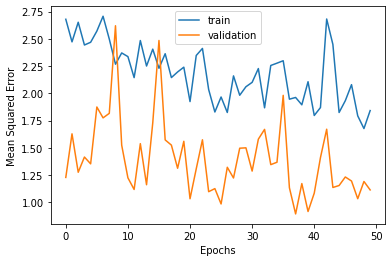

In [ ]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()


In [ ]:
y_pred = model_lstm.predict(X_test)

In [ ]:
submission = pd.DataFrame(y_pred,columns=['item_cnt_month'])
submission.to_csv('submission1.csv',index_label='ID')

In [ ]:
callback_list =[EarlyStopping(monitor="val_loss",min_delta=.001, patience=3,mode='auto')]

In [ ]:
hist = model_lstm.fit(X_train, Y_train,validation_data=(X_valid, Y_valid),epochs = 20 , batch_size = 2048,callbacks = callback_list,shuffle = True)

Epoch 1/20
4482/4482 [==============================] - 52s 12ms/step - loss: 1.8533 - mse: 1.8533 - val_loss: 1.3766 - val_mse: 1.3766
Epoch 2/20
4482/4482 [==============================] - 51s 11ms/step - loss: 1.9671 - mse: 1.9671 - val_loss: 1.1982 - val_mse: 1.1982
Epoch 3/20
4482/4482 [==============================] - 52s 11ms/step - loss: 1.9069 - mse: 1.9069 - val_loss: 1.2307 - val_mse: 1.2307
Epoch 4/20
4482/4482 [==============================] - 52s 12ms/step - loss: 1.9263 - mse: 1.9263 - val_loss: 1.0275 - val_mse: 1.0275
Epoch 5/20
4482/4482 [==============================] - 52s 12ms/step - loss: 1.6895 - mse: 1.6895 - val_loss: 1.2626 - val_mse: 1.2626
Epoch 6/20
4482/4482 [==============================] - 52s 12ms/step - loss: 1.6996 - mse: 1.6996 - val_loss: 0.8635 - val_mse: 0.8635
Epoch 7/20
4482/4482 [==============================] - 52s 12ms/step - loss: 1.8900 - mse: 1.8900 - val_loss: 1.2788 - val_mse: 1.2788
Epoch 8/20
4482/4482 [==========================

In [ ]:
best2 = np.argmin(hist.history["val_loss"])
print("Best optimal epoch:",best2)
print("Train Score: {}, Validation Score: {}".format(hist.history["loss"][best2],hist.history["val_loss"][best2]))

Best optimal epoch: 5
Train Score: 1.6995941400527954, Validation Score: 0.8635269999504089


In [ ]:
y_pred2 = model_lstm.predict(X_test)

In [ ]:
submission2 = pd.DataFrame(y_pred2,columns=['item_cnt_month'])
submission2.to_csv('submission2.csv',index_label='ID')

In [ ]:
hist = model_lstm.fit(X_train, Y_train,validation_data=(X_valid, Y_valid),epochs = 50 , batch_size = 2048,callbacks = callback_list,shuffle = True)

Epoch 1/50
4482/4482 [==============================] - 51s 11ms/step - loss: 1.7028 - mse: 1.7028 - val_loss: 0.9191 - val_mse: 0.9191
Epoch 2/50
4482/4482 [==============================] - 51s 11ms/step - loss: 1.8382 - mse: 1.8382 - val_loss: 1.2085 - val_mse: 1.2085
Epoch 3/50
4482/4482 [==============================] - 51s 11ms/step - loss: 1.8117 - mse: 1.8117 - val_loss: 1.0133 - val_mse: 1.0133
Epoch 4/50
4482/4482 [==============================] - 51s 11ms/step - loss: 1.7071 - mse: 1.7071 - val_loss: 0.8766 - val_mse: 0.8766
Epoch 5/50
4482/4482 [==============================] - 51s 11ms/step - loss: 1.9828 - mse: 1.9828 - val_loss: 1.2120 - val_mse: 1.2120
Epoch 6/50
4482/4482 [==============================] - 51s 11ms/step - loss: 1.6282 - mse: 1.6282 - val_loss: 1.0719 - val_mse: 1.0719
Epoch 7/50
4482/4482 [==============================] - 51s 11ms/step - loss: 1.7299 - mse: 1.7299 - val_loss: 0.8664 - val_mse: 0.8664
Epoch 8/50
4482/4482 [==========================

In [ ]:
best3 = np.argmin(hist.history["val_loss"])
print("Best optimal epoch:",best3)
print("Train Score: {}, Validation Score: {}".format(hist.history["loss"][best3],hist.history["val_loss"][best3]))

Best optimal epoch: 6
Train Score: 1.7299339771270752, Validation Score: 0.8663879632949829


In [ ]:
y_pred3 = model_lstm.predict(X_test)

In [ ]:
submission3 = pd.DataFrame(y_pred3,columns=['item_cnt_month'])
submission3.to_csv('submission3.csv',index_label='ID')#Kaggle best score

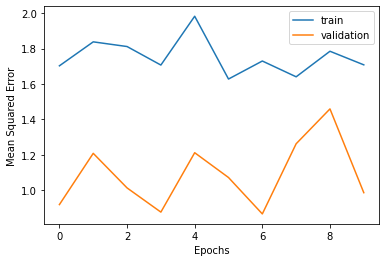

In [ ]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

In [ ]:
# Delete the temporary data DataFrame
del data, train, test, shops, cats, items, group

In [ ]:
import gc
gc.collect()

176